In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use("seaborn-v0_8")

In [2]:
# ============================
# Configuration
# ============================
start_date = "2020-01-01"
sequence_length = 30      # number of past days to look at
train_ratio = 0.7         # 80% train, 20% test
num_epochs = 200
learning_rate = 1e-3
hidden_size = 64
num_layers = 2
dropout = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [11]:
# 1. Try relative path from current working directory
db_path = Path("data") / "processed" / "data_processed.sqlite"

# If that does not exist, assume we are inside model/ and go one level up
if not db_path.exists():
    project_root = Path().resolve().parent      # one level up
    db_path = project_root / "data" / "processed" / "data_processed.sqlite"

print("SQLite path:", db_path)
print("Exists:", db_path.exists())
if not db_path.exists():
    raise FileNotFoundError(f"Processed SQLite DB not found at {db_path}")

# 2. Parameters
start_date = "2000-01-01"
ticker = "NVDA"

# 3. Load from SQLite
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(
        """
        SELECT Date, Close
        FROM data
        WHERE Date >= ?
        ORDER BY Date;
        """,
        conn,
        params=(start_date,),
        parse_dates=["Date"],
    )

print(df.head())
print(df.dtypes)

# 4. Use Date as index and keep Close as price
df.set_index("Date", inplace=True)
close_prices = df[["Close"]].dropna()

print(close_prices.head())
print("Total rows:", len(close_prices))

SQLite path: data\processed\data_processed.sqlite
Exists: True
        Date     Close
0 2000-10-16  0.322404
1 2000-10-17  0.301785
2 2000-10-18  0.301785
3 2000-10-19  0.283978
4 2000-10-20  0.292412
Date     datetime64[ns]
Close           float64
dtype: object
               Close
Date                
2000-10-16  0.322404
2000-10-17  0.301785
2000-10-18  0.301785
2000-10-19  0.283978
2000-10-20  0.292412
Total rows: 6323


In [12]:
# ============================
# 2. Features & scaling
# ============================
df = close_prices.copy()  # index = Date, column Close

# Make sure Close is numeric
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna(subset=["Close"])

# Log-returns and technical features
df["log_ret"]  = np.log(df["Close"]).diff()
df["vol_5"]    = df["log_ret"].rolling(5).std()
df["vol_20"]   = df["log_ret"].rolling(20).std()
df["ma_10"]    = df["Close"].rolling(10).mean()
df["ma_30"]    = df["Close"].rolling(30).mean()
df["ma_ratio"] = df["ma_10"] / df["ma_30"]

df = df.dropna()

feature_cols = ["log_ret", "vol_5", "vol_20", "ma_ratio"]
target_col   = "log_ret"  # predict next-day log return

X_raw = df[feature_cols].values
y_raw = df[target_col].shift(-1).values  # next day target

# Drop last row where shift(-1) is NaN
df    = df.iloc[:-1]
X_raw = X_raw[:-1]
y_raw = y_raw[:-1]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# ============================
# 3. Sequence creation
# ============================
def create_sequences(X: np.ndarray, y: np.ndarray, window: int):
    """
    X: shape (N, n_features)
    y: shape (N,)
    window: number of time steps in the input sequence

    Returns:
        X_seq: shape (N - window, window, n_features)
        y_seq: shape (N - window,)
    """
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i : i + window])
        ys.append(y[i + window])
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_raw, sequence_length)
print("X_all shape:", X_all.shape)  # (num_samples, seq_len, n_features)
print("y_all shape:", y_all.shape)

n_samples, seq_len, n_features = X_all.shape

# ============================
# 4. Train / test split
# ============================
train_ratio = 0.7

train_end = int(n_samples * train_ratio)

X_train_np, y_train_np = X_all[:train_end],  y_all[:train_end]
X_test_np,  y_test_np  = X_all[train_end:],  y_all[train_end:]

# ============================
# 5. Tensors
# ============================
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(-1).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).unsqueeze(-1).to(device)

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

X_all shape: (6263, 30, 4)
y_all shape: (6263,)
Train samples: 4384
Test samples : 1879


In [13]:
# ============================
# 6. LSTM model (returns)
# ============================
class ReturnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)          # (batch, seq_len, hidden_size)
        last_out = out[:, -1, :]       # (batch, hidden_size)
        return self.fc(last_out)       # (batch, 1)


# Infer number of features from training data
n_features = X_train.shape[2]

# Ensure y_* tensors are (N, 1)
if y_train.ndim == 1:
    y_train = y_train.view(-1, 1)
if y_test.ndim == 1:
    y_test = y_test.view(-1, 1)

model = ReturnLSTM(
    input_size=n_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.3,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ============================
# 7. Training loop (train/test only)
# ============================
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | train={loss.item():.6f}")

# ============================
# 8. Evaluation (returns + direction)
# ============================
model.eval()
with torch.no_grad():
    train_pred = model(X_train).cpu().numpy().flatten()
    test_pred  = model(X_test).cpu().numpy().flatten()

y_train_true = y_train.cpu().numpy().flatten()
y_test_true  = y_test.cpu().numpy().flatten()

def rmse(a, b):
    return np.sqrt(((a - b) ** 2).mean())

print(f"Train RMSE (ret): {rmse(y_train_true, train_pred):.6f}")
print(f"Test  RMSE (ret): {rmse(y_test_true,  test_pred):.6f}")

# Directional accuracy
test_dir_acc = (np.sign(test_pred) == np.sign(y_test_true)).mean() * 100
print(f"Test directional accuracy: {test_dir_acc:.2f}%")

Epoch   1 | train=0.002798
Epoch  20 | train=0.000601
Epoch  40 | train=0.000537
Epoch  60 | train=0.000534
Epoch  80 | train=0.000533
Epoch 100 | train=0.000533
Epoch 120 | train=0.000532
Epoch 140 | train=0.000534
Epoch 160 | train=0.000532
Epoch 180 | train=0.000532
Epoch 200 | train=0.000532
Train RMSE (ret): 0.023066
Test  RMSE (ret): 0.019652
Test directional accuracy: 53.65%


Price test RMSE: 88.0042936674726


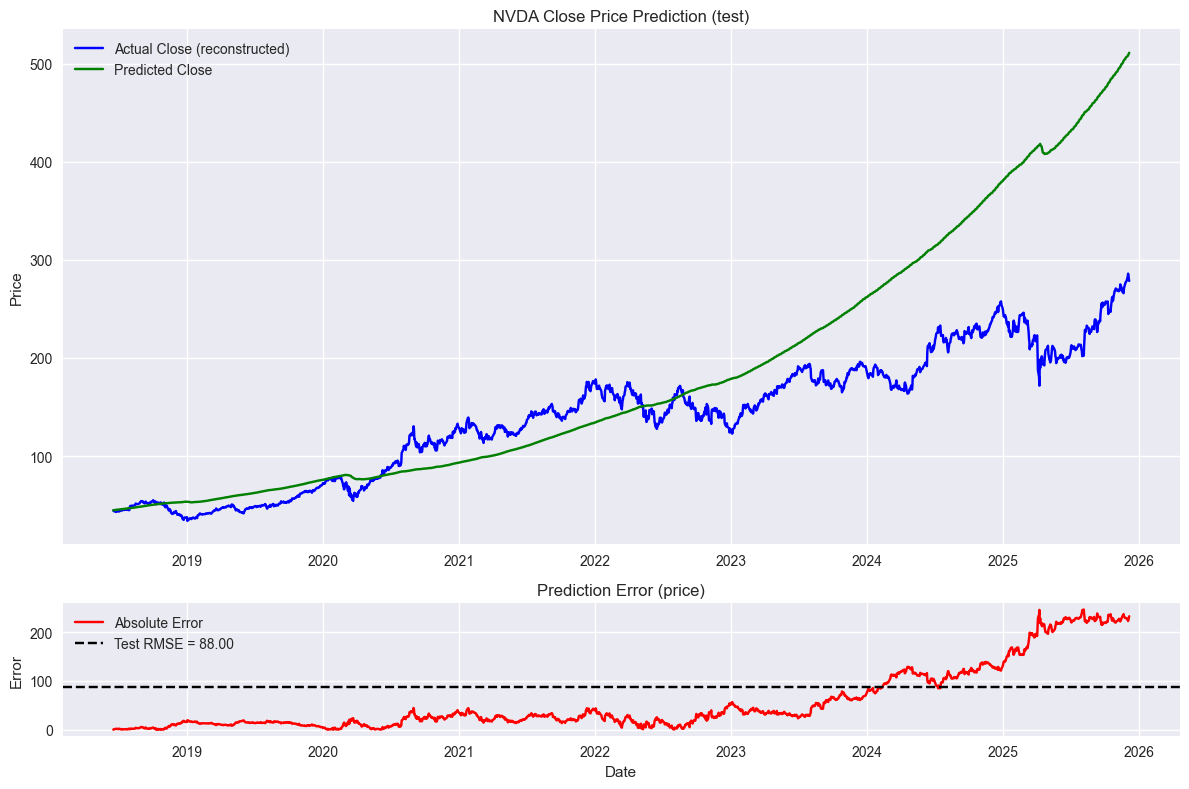

In [14]:
# ============================
# 9. Reconstruct and plot prices (test)
# ============================

# 1) ensure numeric dtypes
y_test_true = np.asarray(y_test_true, dtype=float).reshape(-1)
test_pred   = np.asarray(test_pred,   dtype=float).reshape(-1)

if len(y_test_true) != len(test_pred):
    raise ValueError(f"len(y_test_true)={len(y_test_true)} != len(test_pred)={len(test_pred)}")

N = len(y_test_true)
if len(close_prices) < N:
    raise ValueError(f"close_prices has only {len(close_prices)} rows, but test set has {N}")

# 2) align dates and actual prices to test horizon
test_dates   = close_prices.index[-N:]
actual_price = close_prices["Close"].iloc[-N:].values  # shape (N,)

# 3) reconstruct prices from log-returns
p0 = float(actual_price[0])

cum_true = np.cumsum(y_test_true)
cum_pred = np.cumsum(test_pred)

y_test_price    = p0 * np.exp(cum_true)
test_pred_price = p0 * np.exp(cum_pred)

# 4) RMSE in price space
def rmse(a, b):
    return np.sqrt(((a - b) ** 2).mean())

test_rmse = rmse(y_test_price, test_pred_price)
print("Price test RMSE:", test_rmse)

# 5) plot
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(test_dates, y_test_price,    label="Actual Close (reconstructed)", color="blue")
ax1.plot(test_dates, test_pred_price, label="Predicted Close",             color="green")
ax1.set_title(f"{ticker} Close Price Prediction (test)")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)
abs_err = np.abs(y_test_price - test_pred_price)
ax2.plot(test_dates, abs_err, color="red", label="Absolute Error")
ax2.axhline(test_rmse, color="black", linestyle="--",
            label=f"Test RMSE = {test_rmse:.2f}")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error (price)")
ax2.legend()

plt.tight_layout()
plt.show()

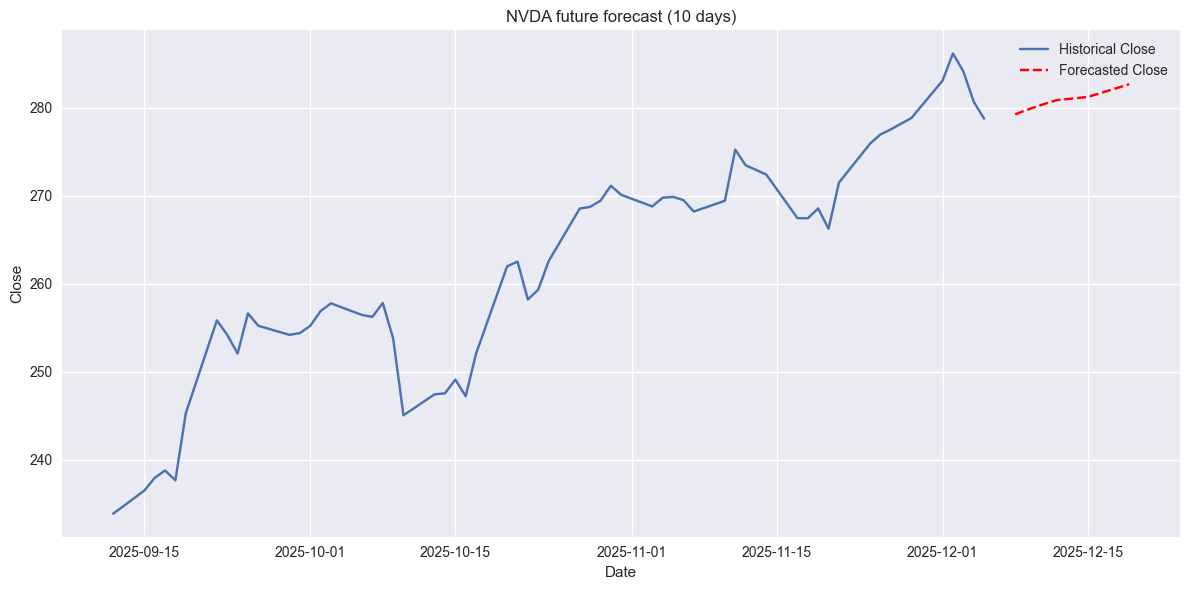

In [15]:
# ============================
# 10. Future forecasting (from feature-based LSTM)
# ============================
def forecast_future_returns(model, last_X_window, steps=10, device="cpu"):
    """
    model: trained ReturnLSTM
    last_X_window: np.ndarray of shape (seq_len, n_features) - last training window from X_scaled
    steps: number of future steps to roll out
    """
    model.eval()
    window = torch.tensor(last_X_window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, seq_len, n_features)
    future_returns = []

    with torch.no_grad():
        for _ in range(steps):
            # model predicts next log-return (batch, 1)
            next_ret = model(window)                      # (1, 1)
            future_returns.append(next_ret.cpu().numpy()[0, 0])  # scalar

            # build a dummy feature vector for the next step:
            # we only know the predicted log_ret; other features set to 0 (or last known)
            next_feat = np.zeros((1, X_train_np.shape[2]), dtype=np.float32)
            next_feat[0, 0] = future_returns[-1]          # put predicted log_ret in first feature

            next_feat_t = torch.tensor(next_feat, dtype=torch.float32).to(device)  # (1, n_features)
            next_feat_t = next_feat_t.unsqueeze(1)        # (1, 1, n_features)

            # roll window
            window = torch.cat([window[:, 1:, :], next_feat_t], dim=1)

    return np.array(future_returns)  # shape (steps,)


# 1) last window of features from your full scaled feature matrix
#    use the same X_scaled used to build X_all
last_X_window = X_scaled[-sequence_length:]  # (seq_len, n_features)

future_days = 10
future_log_rets = forecast_future_returns(
    model=model,
    last_X_window=last_X_window,
    steps=future_days,
    device=device,
)

# 2) reconstruct future prices from last known close
close_prices["Close"] = pd.to_numeric(close_prices["Close"], errors="coerce")
close_prices = close_prices.dropna(subset=["Close"])

last_close = float(close_prices["Close"].iloc[-1])

# cumulative predicted log-returns
cum_future = np.cumsum(future_log_rets)
future_closes = last_close * np.exp(cum_future)  # shape (future_days,)

# 3) build future index (business days after last date)
last_date = close_prices.index[-1]
future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1),
                              periods=future_days)

# 4) Plot recent history + forecast
history_window = 60
history_tail = close_prices.tail(history_window)

plt.figure(figsize=(12, 6))
plt.plot(history_tail.index, history_tail["Close"], label="Historical Close")
plt.plot(future_index, future_closes, "r--", label="Forecasted Close")
plt.title(f"{ticker} future forecast ({future_days} days)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# ============================
# 11. Signals from 10-day forecast
# ============================

# 1) Put forecast into a DataFrame
df_future = pd.DataFrame(
    {"Pred_Close": np.asarray(future_closes, dtype=float).flatten()},
    index=future_index,
)
df_future.index.name = "Date"

# 2) Last actual close
last_actual_close = float(close_prices["Close"].iloc[-1])

# 3) Compute predicted 1-day returns
#    First return compares first forecast to last actual close,
#    subsequent returns are pct_change of Pred_Close.
pred_prices = df_future["Pred_Close"].values  # shape (N,)

pred_returns = np.empty_like(pred_prices, dtype=float)
pred_returns[0] = (pred_prices[0] - last_actual_close) / last_actual_close
pred_returns[1:] = (pred_prices[1:] - pred_prices[:-1]) / pred_prices[:-1]

df_future["pred_ret"] = pred_returns

# 4) Apply rule: > +3% -> 1, < -2% -> -1, else 0
df_future["signal"] = 0
df_future.loc[df_future["pred_ret"] >  0.015, "signal"] = 1
df_future.loc[df_future["pred_ret"] < -0.01, "signal"] = -1

print("Forecasts and signals for next 10 days:")
print(df_future)

Forecasts and signals for next 10 days:
            Pred_Close  pred_ret  signal
Date                                    
2025-12-08  279.263428  0.001734       0
2025-12-09  279.713348  0.001611       0
2025-12-10  280.127136  0.001479       0
2025-12-11  280.510925  0.001370       0
2025-12-12  280.877777  0.001308       0
2025-12-15  281.237671  0.001281       0
2025-12-16  281.596191  0.001275       0
2025-12-17  281.955902  0.001277       0
2025-12-18  282.317780  0.001283       0
2025-12-19  282.681915  0.001290       0


In [19]:
# ============================
# Historical signals from model outputs (feature-based LSTM)
# ============================

model.eval()
with torch.no_grad():
    all_pred_ret = model(torch.tensor(X_all, dtype=torch.float32).to(device)) \
                       .cpu().numpy().reshape(-1)   # predicted next-day log returns

all_true_ret = y_all.reshape(-1)  # true next-day log returns

# Align dates with y_all:
# X_all was built from X_scaled with window=sequence_length
# so the first target corresponds to index sequence_length + (window-1) in the original df.
# For simplicity, align to the last len(y_all) dates of df:
hist_dates = df.index[-len(y_all):]

signals = pd.DataFrame(index=hist_dates)
signals["true_log_ret"] = all_true_ret
signals["pred_log_ret"] = all_pred_ret

# Reconstruct prices for plotting / sanity check (optional)
# Start from the last known close before this window
# Use df["Close"] aligned with hist_dates
start_price = float(df["Close"].iloc[-len(y_all)-1])

cum_true = np.cumsum(all_true_ret)
cum_pred = np.cumsum(all_pred_ret)

signals["true_price"] = start_price * np.exp(cum_true)
signals["pred_price"] = start_price * np.exp(cum_pred)

# Convert predicted log-returns to simple 1-day returns for the rule
signals["pred_ret"] = np.exp(signals["pred_log_ret"]) - 1.0

# Apply rule: > +2% -> long, < -2% -> short, else flat (adjust thresholds as you want)
signals["signal"] = 0
signals.loc[signals["pred_ret"] >  0.015, "signal"] = 1
signals.loc[signals["pred_ret"] < -0.01, "signal"] = -1

signals.dropna(inplace=True)
print(signals.head())

from pathlib import Path
project_root = Path().resolve().parent  # model -> project root
out_path = project_root / "data" / "signals" / "lstmsignal.csv"
signals.to_csv(out_path)
print("Saved historical signals to:", out_path)

            true_log_ret  pred_log_ret  true_price  pred_price  pred_ret  \
Date                                                                       
2001-01-10      0.083232     -0.000829    0.280106    0.257522 -0.000829   
2001-01-11     -0.046190     -0.000208    0.267462    0.257469 -0.000208   
2001-01-12     -0.003643     -0.001013    0.266489    0.257208 -0.001013   
2001-01-16     -0.018418     -0.000533    0.261626    0.257071 -0.000533   
2001-01-17      0.105732     -0.000503    0.290803    0.256942 -0.000503   

            signal  
Date                
2001-01-10       0  
2001-01-11       0  
2001-01-12       0  
2001-01-16       0  
2001-01-17       0  


OSError: Cannot save file into a non-existent directory: 'C:\Users\soltv\Documents\GitHub\data\signals'

In [35]:
# Direction accuracy (up/down)
actual_diff = np.diff(y_test_price.flatten())
pred_diff   = np.diff(test_pred_price.flatten())
actual_dir = np.sign(actual_diff)
pred_dir   = np.sign(pred_diff)
direction_accuracy = np.mean(actual_dir == pred_dir) * 100
print(f"Direction accuracy (up/down): {direction_accuracy:.2f}%")

Direction accuracy (up/down): 49.80%


Using device: cpu
SQLite path: C:\Users\soltv\Documents\GitHub\newalgotrade\data\processed\data_proc.sqlite
                         Close
Date                          
2000-01-03  0.8392805457115173
2000-01-04  0.7685208320617676
2000-01-05  0.7797667980194092
2000-01-06  0.7122870683670044
2000-01-07   0.746027410030365
Total rows: 6522
Total points: 6522
X_train: (5157, 60, 1) y_train: (5157, 1)
X_test : (1245, 60, 1) y_test : (1245, 1)
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Epoch [1/100] Loss: 0.009817
Epoch [10/100] Loss: 0.005510
Epoch [20/100] Loss: 0.004995
Epoch [30/100] Loss: 0.004661
Epoch [40/100] Loss: 0.004260
Epoch [50/100] Loss: 0.003304
Epoch [60/100] Loss: 0.000910
Epoch [70/100] Loss: 0.000215
Epoch [80/100] Loss: 0.000073
Epoch [90/100] Loss: 0.000041
Epoch [100/100] Loss: 0.000029
Test RMSE (price): 21.6827


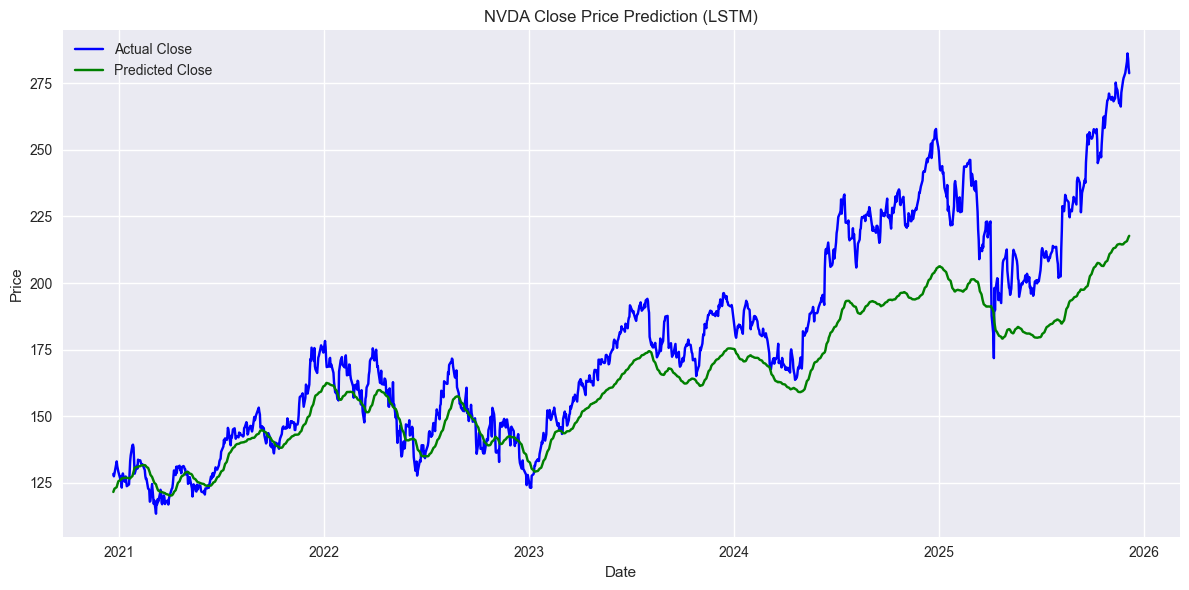

            Actual_Close  Pred_Close  pred_ret  signal
Date                                                  
2020-12-23    127.483292  122.209084 -0.048059      -1
2020-12-24    128.466492  122.805283 -0.036695      -1
2020-12-28    133.061218  123.416298 -0.039311      -1
2020-12-29    131.289505  124.210670 -0.066515      -1
2020-12-30    130.170029  124.967567 -0.048153      -1
Saved historical signals to: C:\Users\soltv\Documents\GitHub\newalgotrade\data\signals_lstm_hist.csv


In [ ]:
# ============================================
# LSTM for NVDA Close Prices (Codegenes-style)
# ============================================

# 0. Imports & device
from pathlib import Path
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# 1. Load NVDA from SQLite: data/processed/data_proc.sqlite, table 'data'
try:
    project_root = Path(PROJECT_ROOT)  # if injected
except NameError:
    project_root = Path().resolve().parent  # running from model/

processed_dir = project_root / "data" / "processed"
sqlite_path = processed_dir / "data_proc.sqlite"

print("SQLite path:", sqlite_path)
if not sqlite_path.exists():
    raise FileNotFoundError(f"Processed SQLite DB not found at {sqlite_path}")

with sqlite3.connect(sqlite_path) as conn:
    df = pd.read_sql(
        """
        SELECT Date, Close
        FROM data
        ORDER BY Date;
        """,
        conn,
        parse_dates=["Date"],
    )

df.set_index("Date", inplace=True)
close_prices = df[["Close"]].dropna()
ticker = "NVDA"

print(close_prices.head())
print("Total rows:", len(close_prices))


# 2. Prepare data (prices vector + dates)
close_prices["Close"] = pd.to_numeric(close_prices["Close"], errors="coerce")
close_prices = close_prices.dropna(subset=["Close"])

data = close_prices["Close"].values.reshape(-1, 1)  # (N, 1)
dates = close_prices.index
print("Total points:", len(data))


# 3. Scale & train/test split
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)  # (N, 1)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data  = scaled_data[train_size:]


def create_sequences(arr, seq_length):
    """
    arr: (N, 1) scaled closes
    returns:
        X: (N - seq_length, seq_length, 1)
        y: (N - seq_length, 1)
    """
    xs, ys = [], []
    for i in range(len(arr) - seq_length):
        x = arr[i : i + seq_length]   # (seq_len, 1)
        y = arr[i + seq_length]       # (1,)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 60
X_train_np, y_train_np = create_sequences(train_data, seq_length)
X_test_np,  y_test_np  = create_sequences(test_data,  seq_length)

print("X_train:", X_train_np.shape, "y_train:", y_train_np.shape)
print("X_test :", X_test_np.shape,  "y_test :", y_test_np.shape)


# 4. Tensors
X_train = torch.from_numpy(X_train_np).float().to(device)
y_train = torch.from_numpy(y_train_np).float().to(device)
X_test  = torch.from_numpy(X_test_np).float().to(device)
y_test  = torch.from_numpy(y_test_np).float().to(device)


# 5. LSTM model (Codegenes-style)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))        # (batch, seq_len, hidden)
        out = self.fc(out[:, -1, :])           # (batch, output_size)
        return out


input_size  = 1
hidden_size = 50
num_layers  = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
print(model)


# 6. Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{num_epochs}] Loss: {loss.item():.6f}")


# 7. Predictions in PRICE space
model.eval()
with torch.no_grad():
    preds_test_scaled = model(X_test).cpu().numpy()      # (N_test, 1)

y_test_scaled = y_test.cpu().numpy()

preds_test_price = scaler.inverse_transform(preds_test_scaled)  # (N_test, 1)
y_test_price     = scaler.inverse_transform(y_test_scaled)      # (N_test, 1)

rmse = np.sqrt(mean_squared_error(y_test_price, preds_test_price))
print(f"Test RMSE (price): {rmse:.4f}")


# 8. Plot actual vs predicted prices (test)
# Align test dates to y_test_price: last len(y_test_price) days
test_len   = len(y_test_price)
test_dates = dates[-test_len:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_price.flatten(),      label="Actual Close",    color="blue")
plt.plot(test_dates, preds_test_price.flatten(),  label="Predicted Close", color="green")
plt.title(f"{ticker} Close Price Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


# 9. Simple trading signals from test predictions
signals = pd.DataFrame(index=test_dates)
signals["Actual_Close"] = y_test_price.flatten()
signals["Pred_Close"]   = preds_test_price.flatten()

# Predicted 1-day returns based on Pred_Close vs previous Actual_Close
signals["pred_ret"] = (signals["Pred_Close"] - signals["Actual_Close"].shift(1)) / signals["Actual_Close"].shift(1)
signals.dropna(inplace=True)

signals["signal"] = 0
signals.loc[signals["pred_ret"] >  0.015, "signal"] = 1   # > +3% -> long
signals.loc[signals["pred_ret"] < -0.01, "signal"] = -1  # < -2% -> short

print(signals.head())

out_path = project_root / "data" / "signals_lstm_hist.csv"
signals.to_csv(out_path)
print("Saved historical signals to:", out_path)